In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 8*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-15 14:14:47.484937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 14:14:47.679338: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-15 14:14:48.359229: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Note to remember
# In this form of reshaping the datasets, u, u_xx, u_yy, u_t, v, v_xx and v_yy, v_t must be transposed to correctly show x and y coordinates

# This note book use only one snapshot (the last), does not estimate the time derivatives and use the exact u and v to reduce the loss residual. FInaly, the parameters are constant.

In [3]:
sim_name = "Koch_Meinhardt_1"
x_slice=slice(0,100,1)#slice(30,65,1)#slice(0,100,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,100,1)#slice(50,85,1)#slice(0,100,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-3,
               data_time_len=2,
               data_time_step=1)

x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]

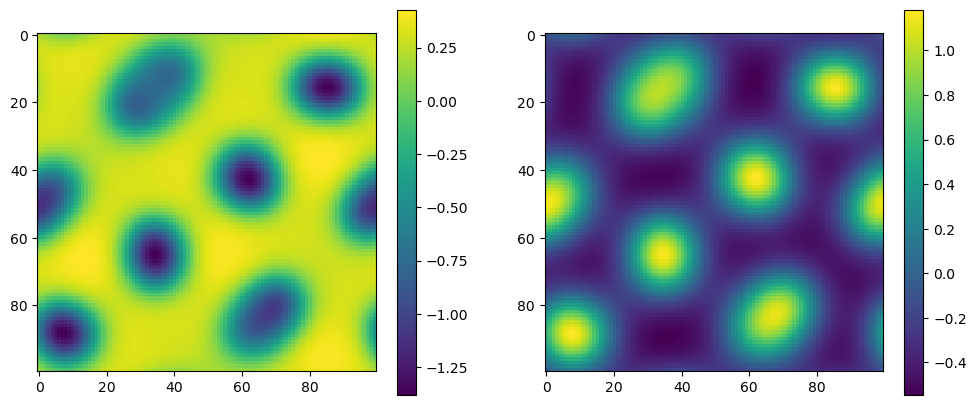

In [4]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(122)
plt.imshow(pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1])
plt.colorbar()

In [5]:
x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)
# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)
X, Y = tf.meshgrid(x, y)
ts = tf.constant(pattern.t_star[-1:], dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
H = tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )

In [6]:
H.shape

TensorShape([1, 100, 100, 3])

In [7]:
def grads(pinn, inputs):    
    with tf.GradientTape(persistent=True) as tape:        
        tape.watch(inputs)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(inputs)            
            outputs = pinn.net(inputs)            
        
            u = tf.squeeze(outputs[:, 0])
            v = tf.squeeze(outputs[:, 1])
            
            grad_u = tape2.gradient(u, inputs)
            u_x = grad_u[:, 0]
            u_y = grad_u[:, 1]
            u_t = grad_u[:, 2]
            
            grad_v = tape2.gradient(v, inputs)
            v_x = grad_v[:, 0]
            v_y = grad_v[:, 1]
            v_t = grad_v[:, 2]
                    
        grad_u_x = tape.gradient(u_x, inputs)
        u_xx = grad_u_x[:, 0]
        #u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, inputs)
        #u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, 1]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, inputs)
        v_xx = grad_v_x[:, 0]
        #v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, inputs)
        #v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, 1]
        #v_ty = grad_v_y[:, :, :, 2]
                                     
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_t))


In [8]:
class NN2(tu.NN):
    def build(self):
        """Create the state of the layers (weights)"""
        self.weights = []
        self.scales = []
        self.biases = []
        for i in range(0, self.num_layers - 1):
            W = self.xavier_init(size=[self.layers[i], self.layers[i + 1]])
            a = tf.Variable(tf.ones([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            b = tf.Variable(tf.zeros([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)
        
        
    @tf.function
    def net(self, inputs):
        # Map the inputs to the range [-1, 1]
        H = 2.0 * (inputs - self.lb) / (self.ub - self.lb) - 1.0
        for W, a ,b in zip(self.weights[:-1], self.scales[:-1], self.biases[:-1]):
            outputs = tf.matmul(H, W)
            H = tf.tanh(a*outputs + b)

        W = self.weights[-1]
        a = self.scales[-1]
        b = self.biases[-1]
        outputs = tf.matmul(H, W)
        outputs = a*outputs + b*b/2.0
        return outputs

In [14]:
lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
pinn = NN2([3, 128, 128, 2], lb, ub, tf.float32)

In [15]:
optimizer=keras.optimizers.Adam(learning_rate=1e-2)

D_u = tf.constant(pattern.params["D_u"], pinn.dtype, name="D_u")
D_v = tf.constant(pattern.params["D_v"], pinn.dtype, name="D_v")
def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 1e-4, 1e10,)

def create_tf_params_new(init_per = 4.0):
    sigma_u = tf.Variable(pattern.params["sigma_u"]*init_per,
                          pinn.dtype,
                          name="sigma_u",
                          constraint=clip_by_value_zero_lb)

    sigma_v = tf.Variable(pattern.params["sigma_v"]*init_per,
                          pinn.dtype,
                          name="sigma_v",
                          constraint=clip_by_value_zero_lb)

    mu_u = tf.Variable(pattern.params["mu_u"]*init_per,
                       pinn.dtype,
                       name="mu_u",
                       constraint=clip_by_value_zero_lb)

    rho_u = tf.Variable(pattern.params["rho_u"]*init_per,
                        pinn.dtype,
                        name="rho_u",
                        constraint=clip_by_value_zero_lb)

    rho_v = tf.Variable(pattern.params["rho_v"]*init_per,
                        pinn.dtype,
                        name="rho_v",
                        constraint=clip_by_value_zero_lb)

    kappa_u = tf.Variable(pattern.params["kappa_u"]*init_per,
                          pinn.dtype,
                          name="kappa_u",
                          constraint=clip_by_value_zero_lb)
    
    return (sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,)

sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u = create_tf_params_new(init_per = 4.0)


@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = elements[0]
        tape.watch(H)
        trainables = pinn.trainable_variables

        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)
            
            outputs = pinn.net(H)
            ug = tf.squeeze(outputs[:, 0])
            vg = tf.squeeze(outputs[:, 1])
            
            grad_u = tape2.gradient(ug, H)
            u_x = grad_u[:, 0]
            u_y = grad_u[:, 1]
            #u_t = grad_u[:, 2]
            
            grad_v = tape2.gradient(vg, H)
            v_x = grad_v[:, 0]
            v_y = grad_v[:, 1]
            #v_t = grad_v[:, 2]
                    
        grad_u_x = tape.gradient(u_x, H)
        u_xx = grad_u_x[:, 0]
        #u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, H)
        #u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, 1]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, H)
        v_xx = grad_v_x[:, 0]
        #v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, H)
        #v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, 1]
        #v_ty = grad_v_y[:, :, :, 2]
                             
        u = tf.squeeze(elements[1][:, 0])
        v = tf.squeeze(elements[1][:, 1])
        #print(u)
        #print(u_xx)
        f = u * u * v / (1.0 + kappa_u * u * u)
        #print(u_xx.shape)
        #print(f.shape)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u# - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v# - v_t
        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
#         u_diff = u - elements[1][:, 0, :, :]
#         v_diff = v - elements[1][:, 1, :, :]
#         l2_u_obs = tf.reduce_sum(u_diff**2)
#         l2_v_obs = tf.reduce_sum(v_diff**2)

                
        #l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v
        l2 = l2_res_u + l2_res_v
        
    #print(trainables)  
    grads = tape.gradient(l2, trainables)

#     print("=================================")
#     print(list(grads))
#     print()
    optimizer.apply_gradients(zip(grads, trainables))
    #return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v)
    return (l2_res_u, l2_res_v)

In [16]:
# Data is a three column matrix as (x,y,t), where
# first x changes, then y, and finally t (like Boolean tables)
data = tf.reshape(H, (H.shape[0]*H.shape[1]*H.shape[2],3))

In [17]:
#Select the last time step
# and reorder the x and y to match it
# with H
c_copy = np.einsum("cxy -> cyx", pattern.c[..., -1].copy())
#reshape c to flatten the data for each species
c = c_copy.reshape((2, pattern.c.shape[1]*pattern.c.shape[2]))
# and finnaly use its transposed, to have the each speacices in on column 
c = c.T
def gen_series():    
    
    for i in range(data.shape[0]):
        h = data[i,:]
        yield h, c[i,:]    
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((3,),(2,)))

In [18]:
batch_size = 5000
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f"  u: {losses[0]},  v: {losses[1]},\n"
           # f" Res u: {losses[1]}, Res v: {losses[2]},\n"
           )
    
losses = tu.train(epochs=10000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 2,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=5e-1,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 58986.9970703125  u: 28607.650390625,  v: 30379.3466796875,

Time taken: 22.44s

Start of epoch 100
at epoch 100
 total loss: 4874.4803466796875  u: 2973.3321533203125,  v: 1901.148193359375,

Time taken: 5.57s

Start of epoch 200
at epoch 200
 total loss: 1026.8740997314453  u: 635.5047149658203,  v: 391.369384765625,

Time taken: 5.57s

Start of epoch 300
at epoch 300
 total loss: 1196.7625427246094  u: 668.8570861816406,  v: 527.9054565429688,

Time taken: 5.59s

Start of epoch 400
at epoch 400
 total loss: 426.8769836425781  u: 254.8243637084961,  v: 172.05261993408203,

Time taken: 5.78s

Start of epoch 500
at epoch 500
 total loss: 345.6338768005371  u: 203.4144744873047,  v: 142.21940231323242,

Time taken: 5.74s

Start of epoch 600
at epoch 600
 total loss: 688.3414001464844  u: 378.1151580810547,  v: 310.2262420654297,

Time taken: 5.79s

Start of epoch 700
at epoch 700
 total loss: 373.3145294189453  u: 213.12220764160156,  v: 160.192


Start of epoch 6300
at epoch 6300
 total loss: 86.49597835540771  u: 45.10268592834473,  v: 41.39329242706299,

Time taken: 5.70s

Start of epoch 6400
at epoch 6400
 total loss: 184.07072639465332  u: 96.2989616394043,  v: 87.77176475524902,

Time taken: 5.81s

Start of epoch 6500
at epoch 6500
 total loss: 37.665066719055176  u: 20.61909008026123,  v: 17.045976638793945,

Time taken: 5.66s

Start of epoch 6600
at epoch 6600
 total loss: 241.64248275756836  u: 130.39551544189453,  v: 111.24696731567383,

Time taken: 5.72s

Start of epoch 6700
at epoch 6700
 total loss: 20.476099967956543  u: 11.60073709487915,  v: 8.875362873077393,

Time taken: 5.75s

Start of epoch 6800
at epoch 6800
 total loss: 100.76553726196289  u: 55.842132568359375,  v: 44.923404693603516,

Time taken: 5.71s

Start of epoch 6900
at epoch 6900
 total loss: 170.85422134399414  u: 92.20740509033203,  v: 78.64681625366211,

Time taken: 5.67s

Start of epoch 7000
at epoch 7000
 total loss: 230.64154434204102  u: 11

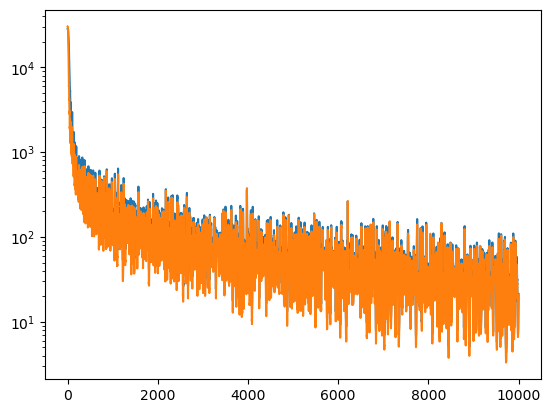

In [19]:
plt.plot(losses[:,0])
plt.plot(losses[:,1])
plt.yscale('log')

In [20]:
(u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t) = grads(pinn, data)

In [21]:
def to(arr):
    return arr.numpy().reshape(y_range.shape[0], x_range.shape[0])

actual_u_der = pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1]
actual_v_der = pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1]

u_der = pattern.params["D_u"]*( to(u_xx) + to(u_yy))# - to(u_t2)[-1, ...]
v_der = pattern.params["D_v"]*( to(v_xx)+ to(v_yy))# - to(v_t2)[-1, ...]
# X and Y are misoriented
u_der = u_der.T
v_der = v_der.T

u = pattern.c[0,:, : , -1]
v = pattern.c[1,:, : , -1]
f = u * u * v / (1.0 + kappa_u * u * u)
f_u =  rho_u * f - mu_u * u + sigma_u
f_v =  - rho_v * f + sigma_v

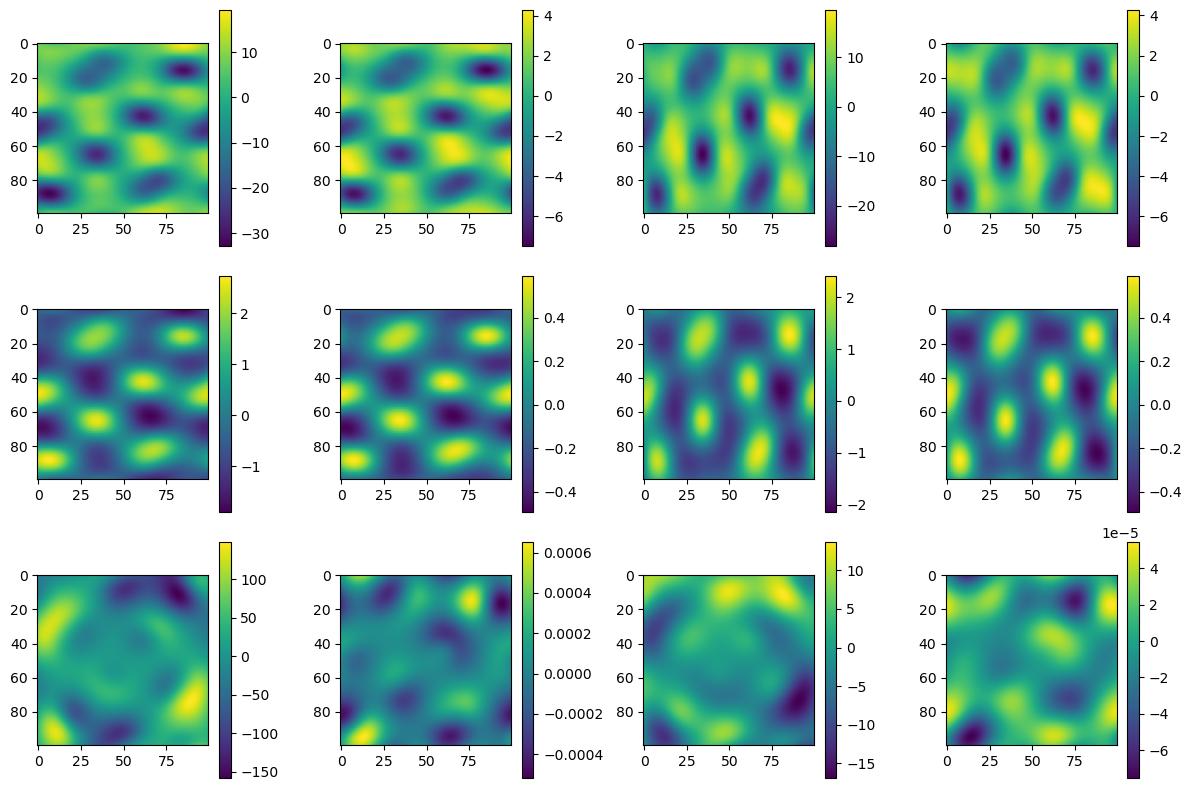

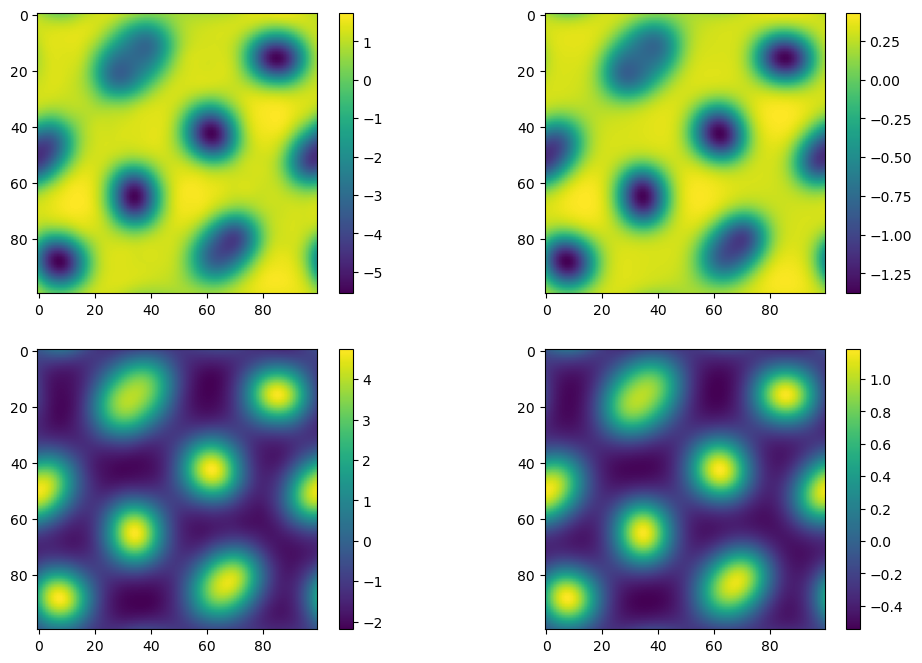

In [22]:


plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(to(u_xx).T)
plt.colorbar()
plt.subplot(342)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(343)
plt.imshow(to(u_yy).T)
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(to(v_xx).T)
plt.colorbar()
plt.subplot(346)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(347)
plt.imshow(to(v_yy).T)
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(to(u_t))
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(to(v_t))
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(u_der)
plt.colorbar()
plt.subplot(222)
plt.imshow(actual_u_der)
plt.colorbar()
plt.subplot(223)
plt.imshow(v_der)
plt.colorbar()
plt.subplot(224)
plt.imshow(actual_v_der)
plt.colorbar()

In [23]:
def create_tf_params_from(sigma_u_old, sigma_v_old, mu_u_old, rho_u_old, rho_v_old, kappa_u_old,):
    sigma_u = tf.Variable(sigma_u_old.numpy(),
                          pinn.dtype,
                          name="sigma_u",
                          constraint=clip_by_value_zero_lb)

    sigma_v = tf.Variable(sigma_v_old.numpy(),
                          pinn.dtype,
                          name="sigma_v",
                          constraint=clip_by_value_zero_lb)

    mu_u = tf.Variable(mu_u_old.numpy(),
                       pinn.dtype,
                       name="mu_u",
                       constraint=clip_by_value_zero_lb)

    rho_u = tf.Variable(rho_u_old.numpy(),
                        pinn.dtype,
                        name="rho_u",
                        constraint=clip_by_value_zero_lb)

    rho_v = tf.Variable(rho_v_old.numpy(),
                        pinn.dtype,
                        name="rho_v",
                        constraint=clip_by_value_zero_lb)

    kappa_u = tf.Variable(kappa_u_old.numpy(),
                          pinn.dtype,
                          name="kappa_u",
                          constraint=clip_by_value_zero_lb)
    
    return (sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,)


In [100]:
pinn2 = pinn.copy()

In [101]:
params_tf

(<tf.Variable 'sigma_u:0' shape=() dtype=float32, numpy=nan>,
 <tf.Variable 'sigma_v:0' shape=() dtype=float32, numpy=nan>,
 <tf.Variable 'mu_u:0' shape=() dtype=float32, numpy=nan>,
 <tf.Variable 'rho_u:0' shape=() dtype=float32, numpy=nan>,
 <tf.Variable 'rho_v:0' shape=() dtype=float32, numpy=nan>,
 <tf.Variable 'kappa_u:0' shape=() dtype=float32, numpy=nan>)

In [119]:
import time


optimizer_params=keras.optimizers.SGD(learning_rate=1e-3)#keras.optimizers.Adam(learning_rate=1e-2)
optimizer_model=keras.optimizers.Adam(learning_rate=1e-2)

params_tf = create_tf_params_from(sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u)

@tf.function
def train_params_step(pinn, params_tf, elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = elements[0]
        tape.watch(H)
        trainables = params_tf        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)
            
            outputs = pinn.net(H)
            ug = tf.squeeze(outputs[:, 0])
            vg = tf.squeeze(outputs[:, 1])
            
            grad_u = tape2.gradient(ug, H)
            u_x = grad_u[:, 0]
            u_y = grad_u[:, 1]
            
            grad_v = tape2.gradient(vg, H)
            v_x = grad_v[:, 0]
            v_y = grad_v[:, 1]
                    
        grad_u_x = tape.gradient(u_x, H)
        u_xx = grad_u_x[:, 0]
        grad_u_y = tape.gradient(u_y, H)
        u_yy = grad_u_y[:, 1]
        grad_v_x = tape.gradient(v_x, H)
        v_xx = grad_v_x[:, 0]
        grad_v_y = tape.gradient(v_y, H)
        v_yy = grad_v_y[:, 1]
                             
        u = tf.squeeze(elements[1][:, 0])
        v = tf.squeeze(elements[1][:, 1])
        sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u = params_tf
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u# - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v# - v_t
        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        l2 = l2_res_u + l2_res_v
        
    grads = tape.gradient(l2, trainables)
    #print(trainables)
    optimizer_params.apply_gradients(zip(grads, trainables))
    #print(trainables)
    return (l2_res_u, l2_res_v)

@tf.function
def train_model_step(pinn, params_tf, elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = elements[0]
        tape.watch(H)
        trainables = pinn.trainable_variables
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)
            
            outputs = pinn.net(H)
            ug = tf.squeeze(outputs[:, 0])
            vg = tf.squeeze(outputs[:, 1])
            
            grad_u = tape2.gradient(ug, H)
            u_x = grad_u[:, 0]
            u_y = grad_u[:, 1]
            
            grad_v = tape2.gradient(vg, H)
            v_x = grad_v[:, 0]
            v_y = grad_v[:, 1]
                    
        grad_u_x = tape.gradient(u_x, H)
        u_xx = grad_u_x[:, 0]
        grad_u_y = tape.gradient(u_y, H)
        u_yy = grad_u_y[:, 1]
        grad_v_x = tape.gradient(v_x, H)
        v_xx = grad_v_x[:, 0]
        grad_v_y = tape.gradient(v_y, H)
        v_yy = grad_v_y[:, 1]
                             
        u = tf.squeeze(elements[1][:, 0])
        v = tf.squeeze(elements[1][:, 1])
        sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u = params_tf
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u# - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v# - v_t
        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        l2 = l2_res_u + l2_res_v
        
    grads = tape.gradient(l2, trainables)
    optimizer_model.apply_gradients(zip(grads, trainables))
    return (l2_res_u, l2_res_v)

def search_train(
    search_epochs,
    epochs,
    batch_size,
    dataset: TINN_Dataset,
    pinn,
    params_tf,
    print_interval=10,
    loss_sample_interval=1,
    loss_reduce=tu.np_sum,
    printer=tu.default_printer,
):
    
    loss_params_samples = np.zeros((search_epochs, 2))
    loss_samples = np.zeros((search_epochs, epochs, 2))
    dataset2 = dataset.cache().batch(batch_size)
    pinn_copy = pinn2.copy()
    for search_i in range(search_epochs):        
        index = 0
        for epoch in range(epochs):
            if print_interval > 0 and epoch % print_interval == 0:
                printer(f"\nStart of epoch {epoch:d}")

            # Iterate over the batches of the dataset.
            for element in dataset2:
                loss = train_model_step(pinn_copy, params_tf, element)
                if epoch % loss_sample_interval == 0:
                    loss_samples[search_i, index, :] += loss
            if print_interval > 0 and epoch % print_interval == 0:            
                printer(f"Loss value: {loss_reduce(loss_samples[search_i, index, :])}, at epoch {epoch:d}")
                printer([(v.name, v.numpy()) for v in params_tf])  
            if epoch % loss_sample_interval == 0:
                index += 1
        min_loss = np.min(np.sum(loss_samples[search_i, :, :], axis=1))
#         print("--"*20)
#         print("--"*20)
#         print(f"minimum loss: {min_loss}")
#         print("Seccond round ---")
#         print("--"*20)
#         print("--"*20)
        # Second round of the model minimisation
#         index = 0
#         for epoch in range(1000):
# #             if print_interval > 0 and epoch % print_interval == 0:
# #                 printer(f"\nStart of epoch {epoch:d}")

#             # Iterate over the batches of the dataset.
#             second_round_losses = np.zeros(2)
#             for element in dataset2:
#                 loss = train_model_step(pinn_copy, params_tf, element)
#                 if epoch % loss_sample_interval == 0:
#                     second_round_losses += loss
# #             if print_interval > 0 and epoch % print_interval == 0:            
# #                 printer(f"Loss value: {loss_reduce(second_round_losses)}, at second round.")
# #                 printer([(v.name, v.numpy()) for v in params_tf])  
#             if min_loss >= float(loss_reduce(second_round_losses)*1.01):
#                 break# breake the second round
                
#             if epoch % loss_sample_interval == 0:
#                 index += 1
        #########################
        printer(f"\nStart of search {search_i:d}")        
        # Parameters minimisation
        for element in dataset2:
            l_res_u, l_res_v = train_params_step(pinn_copy, params_tf, element)        
            loss_params_samples[search_i, :] += np.array([l_res_u, l_res_v])
        printer(f"Loss value at search {search_i}: {loss_reduce(loss_params_samples[search_i, :])}")
        printer([(v.name, v.numpy()) for v in params_tf])      
        # First round of the model minimisation
        print("--"*20)
        print("--"*20)
        
    return pinn_copy, loss_params_samples, loss_samples
        
        

In [120]:
print([(v.name, v.numpy()) for v in params_tf])      

[('sigma_u:0', 4.0), ('sigma_v:0', 4.0), ('mu_u:0', 4.0), ('rho_u:0', 0.4), ('rho_v:0', 0.1), ('kappa_u:0', 0.0)]


In [121]:
pinn_copy, loss_params_samples, loss_samples=search_train(
    search_epochs=200,
    epochs=400+1,
    batch_size=10000,
    dataset=ds,
    pinn=pinn2,
    params_tf=params_tf,
    print_interval=100,
    loss_sample_interval=1,
    loss_reduce=tu.np_sum,
    printer=tu.default_printer,
)


Start of epoch 0
Loss value: 13.400850772857666, at epoch 0
[('sigma_u:0', 4.0), ('sigma_v:0', 4.0), ('mu_u:0', 4.0), ('rho_u:0', 0.4), ('rho_v:0', 0.1), ('kappa_u:0', 0.0)]

Start of epoch 100
Loss value: 6.800887584686279, at epoch 100
[('sigma_u:0', 4.0), ('sigma_v:0', 4.0), ('mu_u:0', 4.0), ('rho_u:0', 0.4), ('rho_v:0', 0.1), ('kappa_u:0', 0.0)]

Start of epoch 200
Loss value: 5.382226467132568, at epoch 200
[('sigma_u:0', 4.0), ('sigma_v:0', 4.0), ('mu_u:0', 4.0), ('rho_u:0', 0.4), ('rho_v:0', 0.1), ('kappa_u:0', 0.0)]

Start of epoch 300
Loss value: 4.959735631942749, at epoch 300
[('sigma_u:0', 4.0), ('sigma_v:0', 4.0), ('mu_u:0', 4.0), ('rho_u:0', 0.4), ('rho_v:0', 0.1), ('kappa_u:0', 0.0)]

Start of epoch 400
Loss value: 5.610257625579834, at epoch 400
[('sigma_u:0', 4.0), ('sigma_v:0', 4.0), ('mu_u:0', 4.0), ('rho_u:0', 0.4), ('rho_v:0', 0.1), ('kappa_u:0', 0.0)]

Start of search 0
Loss value at search 0: 5.494339942932129
[('sigma_u:0', 3.9865313), ('sigma_v:0', 4.0134583),


Start of epoch 200
Loss value: 69.63108921051025, at epoch 200
[('sigma_u:0', 4.0316205), ('sigma_v:0', 3.716832), ('mu_u:0', 0.7179297), ('rho_u:0', 1e-04), ('rho_v:0', 0.14656402), ('kappa_u:0', 3.6500556)]

Start of epoch 300
Loss value: 55.85175895690918, at epoch 300
[('sigma_u:0', 4.0316205), ('sigma_v:0', 3.716832), ('mu_u:0', 0.7179297), ('rho_u:0', 1e-04), ('rho_v:0', 0.14656402), ('kappa_u:0', 3.6500556)]

Start of epoch 400
Loss value: 47.807583808898926, at epoch 400
[('sigma_u:0', 4.0316205), ('sigma_v:0', 3.716832), ('mu_u:0', 0.7179297), ('rho_u:0', 1e-04), ('rho_v:0', 0.14656402), ('kappa_u:0', 3.6500556)]

Start of search 6
Loss value at search 6: 47.75975704193115
[('sigma_u:0', 3.9756594), ('sigma_v:0', 3.7023802), ('mu_u:0', 0.8320463), ('rho_u:0', 1e-04), ('rho_v:0', 0.15209533), ('kappa_u:0', 3.6498373)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 4190.7476263046265, at epoch 0
[('sigma_u:0', 3.9


Start of epoch 300
Loss value: 10.046695947647095, at epoch 300
[('sigma_u:0', 3.9343336), ('sigma_v:0', 3.665393), ('mu_u:0', 0.6625041), ('rho_u:0', 1e-04), ('rho_v:0', 0.1676746), ('kappa_u:0', 3.649189)]

Start of epoch 400
Loss value: 13.488991737365723, at epoch 400
[('sigma_u:0', 3.9343336), ('sigma_v:0', 3.665393), ('mu_u:0', 0.6625041), ('rho_u:0', 1e-04), ('rho_v:0', 0.1676746), ('kappa_u:0', 3.649189)]

Start of search 12
Loss value at search 12: 13.155965805053711
[('sigma_u:0', 3.9645607), ('sigma_v:0', 3.8546205), ('mu_u:0', 0.48201373), ('rho_u:0', 0.0126180975), ('rho_v:0', 0.08654151), ('kappa_u:0', 3.6528654)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 9812.334838867188, at epoch 0
[('sigma_u:0', 3.9645607), ('sigma_v:0', 3.8546205), ('mu_u:0', 0.48201373), ('rho_u:0', 0.0126180975), ('rho_v:0', 0.08654151), ('kappa_u:0', 3.6528654)]

Start of epoch 100
Loss value: 90.30143356323242, at epoch 100
[(


Start of epoch 400
Loss value: 8.809529542922974, at epoch 400
[('sigma_u:0', 3.8746867), ('sigma_v:0', 3.7532878), ('mu_u:0', 0.5111338), ('rho_u:0', 1e-04), ('rho_v:0', 0.129227), ('kappa_u:0', 3.6518278)]

Start of search 18
Loss value at search 18: 8.616836428642273
[('sigma_u:0', 3.871308), ('sigma_v:0', 3.7506156), ('mu_u:0', 0.48606345), ('rho_u:0', 1e-04), ('rho_v:0', 0.13048612), ('kappa_u:0', 3.6517844)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 167.99360024929047, at epoch 0
[('sigma_u:0', 3.871308), ('sigma_v:0', 3.7506156), ('mu_u:0', 0.48606345), ('rho_u:0', 1e-04), ('rho_v:0', 0.13048612), ('kappa_u:0', 3.6517844)]

Start of epoch 100
Loss value: 7.4060540199279785, at epoch 100
[('sigma_u:0', 3.871308), ('sigma_v:0', 3.7506156), ('mu_u:0', 0.48606345), ('rho_u:0', 1e-04), ('rho_v:0', 0.13048612), ('kappa_u:0', 3.6517844)]

Start of epoch 200
Loss value: 6.813471138477325, at epoch 200
[('sigma_u:0', 


Start of epoch 100
Loss value: 24.29129934310913, at epoch 100
[('sigma_u:0', 3.8359928), ('sigma_v:0', 3.65727), ('mu_u:0', 0.53116137), ('rho_u:0', 1e-04), ('rho_v:0', 0.17101236), ('kappa_u:0', 3.6503937)]

Start of epoch 200
Loss value: 13.957494020462036, at epoch 200
[('sigma_u:0', 3.8359928), ('sigma_v:0', 3.65727), ('mu_u:0', 0.53116137), ('rho_u:0', 1e-04), ('rho_v:0', 0.17101236), ('kappa_u:0', 3.6503937)]

Start of epoch 300
Loss value: 11.056587815284729, at epoch 300
[('sigma_u:0', 3.8359928), ('sigma_v:0', 3.65727), ('mu_u:0', 0.53116137), ('rho_u:0', 1e-04), ('rho_v:0', 0.17101236), ('kappa_u:0', 3.6503937)]

Start of epoch 400
Loss value: 9.552637755870819, at epoch 400
[('sigma_u:0', 3.8359928), ('sigma_v:0', 3.65727), ('mu_u:0', 0.53116137), ('rho_u:0', 1e-04), ('rho_v:0', 0.17101236), ('kappa_u:0', 3.6503937)]

Start of search 25
Loss value at search 25: 9.554696798324585
[('sigma_u:0', 3.835086), ('sigma_v:0', 3.6536734), ('mu_u:0', 0.48345315), ('rho_u:0', 1e-04),


Start of epoch 200
Loss value: 23.108439207077026, at epoch 200
[('sigma_u:0', 3.797062), ('sigma_v:0', 3.5273693), ('mu_u:0', 0.51273465), ('rho_u:0', 1e-04), ('rho_v:0', 0.22616574), ('kappa_u:0', 3.6477864)]

Start of epoch 300
Loss value: 17.33341407775879, at epoch 300
[('sigma_u:0', 3.797062), ('sigma_v:0', 3.5273693), ('mu_u:0', 0.51273465), ('rho_u:0', 1e-04), ('rho_v:0', 0.22616574), ('kappa_u:0', 3.6477864)]

Start of epoch 400
Loss value: 13.480329513549805, at epoch 400
[('sigma_u:0', 3.797062), ('sigma_v:0', 3.5273693), ('mu_u:0', 0.51273465), ('rho_u:0', 1e-04), ('rho_v:0', 0.22616574), ('kappa_u:0', 3.6477864)]

Start of search 31
Loss value at search 31: 13.54848164319992
[('sigma_u:0', 3.793334), ('sigma_v:0', 3.516703), ('mu_u:0', 0.45282045), ('rho_u:0', 1e-04), ('rho_v:0', 0.23081085), ('kappa_u:0', 3.6475043)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 950.3132076263428, at epoch 0
[('sigma_u:0',


Start of epoch 300
Loss value: 3.784185528755188, at epoch 300
[('sigma_u:0', 3.7947536), ('sigma_v:0', 3.5862975), ('mu_u:0', 0.34350234), ('rho_u:0', 0.0006527682), ('rho_v:0', 0.2001884), ('kappa_u:0', 3.649522)]

Start of epoch 400
Loss value: 7.285689353942871, at epoch 400
[('sigma_u:0', 3.7947536), ('sigma_v:0', 3.5862975), ('mu_u:0', 0.34350234), ('rho_u:0', 0.0006527682), ('rho_v:0', 0.2001884), ('kappa_u:0', 3.649522)]

Start of search 37
Loss value at search 37: 8.709842205047607
[('sigma_u:0', 3.8474815), ('sigma_v:0', 3.7237983), ('mu_u:0', 0.049093723), ('rho_u:0', 0.022220625), ('rho_v:0', 0.14188258), ('kappa_u:0', 3.6526766)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 25221.259490966797, at epoch 0
[('sigma_u:0', 3.8474815), ('sigma_v:0', 3.7237983), ('mu_u:0', 0.049093723), ('rho_u:0', 0.022220625), ('rho_v:0', 0.14188258), ('kappa_u:0', 3.6526766)]

Start of epoch 100
Loss value: 23.102928638458252


Start of epoch 300
Loss value: 0.48324060440063477, at epoch 300
[('sigma_u:0', 3.9702575), ('sigma_v:0', 3.8344615), ('mu_u:0', 1e-04), ('rho_u:0', 0.067221895), ('rho_v:0', 0.087370805), ('kappa_u:0', 3.6543229)]

Start of epoch 400
Loss value: 0.8685364723205566, at epoch 400
[('sigma_u:0', 3.9702575), ('sigma_v:0', 3.8344615), ('mu_u:0', 1e-04), ('rho_u:0', 0.067221895), ('rho_v:0', 0.087370805), ('kappa_u:0', 3.6543229)]

Start of search 43
Loss value at search 43: 0.7547370195388794
[('sigma_u:0', 3.9410174), ('sigma_v:0', 3.805665), ('mu_u:0', 0.13963428), ('rho_u:0', 0.05461839), ('rho_v:0', 0.099633135), ('kappa_u:0', 3.6542623)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 5696.664813995361, at epoch 0
[('sigma_u:0', 3.9410174), ('sigma_v:0', 3.805665), ('mu_u:0', 0.13963428), ('rho_u:0', 0.05461839), ('rho_v:0', 0.099633135), ('kappa_u:0', 3.6542623)]

Start of epoch 100
Loss value: 89.45183181762695, at epo


Start of epoch 400
Loss value: 0.2677590623497963, at epoch 400
[('sigma_u:0', 3.9715116), ('sigma_v:0', 3.8435106), ('mu_u:0', 1e-04), ('rho_u:0', 0.05335223), ('rho_v:0', 0.07509808), ('kappa_u:0', 3.6549146)]

Start of search 49
Loss value at search 49: 0.2669586315751076
[('sigma_u:0', 3.9702938), ('sigma_v:0', 3.8436348), ('mu_u:0', 0.01879314), ('rho_u:0', 0.053226937), ('rho_v:0', 0.07518185), ('kappa_u:0', 3.6549153)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 95.86242726445198, at epoch 0
[('sigma_u:0', 3.9702938), ('sigma_v:0', 3.8436348), ('mu_u:0', 0.01879314), ('rho_u:0', 0.053226937), ('rho_v:0', 0.07518185), ('kappa_u:0', 3.6549153)]

Start of epoch 100
Loss value: 1.6006998121738434, at epoch 100
[('sigma_u:0', 3.9702938), ('sigma_v:0', 3.8436348), ('mu_u:0', 0.01879314), ('rho_u:0', 0.053226937), ('rho_v:0', 0.07518185), ('kappa_u:0', 3.6549153)]

Start of epoch 200
Loss value: 1.2292909026145935, at


Start of epoch 100
Loss value: 2.276345670223236, at epoch 100
[('sigma_u:0', 3.8887632), ('sigma_v:0', 3.6470819), ('mu_u:0', 1e-04), ('rho_u:0', 0.012223164), ('rho_v:0', 0.1495058), ('kappa_u:0', 3.653991)]

Start of epoch 200
Loss value: 0.7537440061569214, at epoch 200
[('sigma_u:0', 3.8887632), ('sigma_v:0', 3.6470819), ('mu_u:0', 1e-04), ('rho_u:0', 0.012223164), ('rho_v:0', 0.1495058), ('kappa_u:0', 3.653991)]

Start of epoch 300
Loss value: 1.1916160583496094, at epoch 300
[('sigma_u:0', 3.8887632), ('sigma_v:0', 3.6470819), ('mu_u:0', 1e-04), ('rho_u:0', 0.012223164), ('rho_v:0', 0.1495058), ('kappa_u:0', 3.653991)]

Start of epoch 400
Loss value: 1.0445885062217712, at epoch 400
[('sigma_u:0', 3.8887632), ('sigma_v:0', 3.6470819), ('mu_u:0', 1e-04), ('rho_u:0', 0.012223164), ('rho_v:0', 0.1495058), ('kappa_u:0', 3.653991)]

Start of search 56
Loss value at search 56: 1.1238994598388672
[('sigma_u:0', 3.7958808), ('sigma_v:0', 3.5539484), ('mu_u:0', 0.41474503), ('rho_u:0', 


Start of epoch 200
Loss value: 3.888556957244873, at epoch 200
[('sigma_u:0', 3.8853662), ('sigma_v:0', 3.530956), ('mu_u:0', 0.01324782), ('rho_u:0', 0.014464424), ('rho_v:0', 0.16861953), ('kappa_u:0', 3.653786)]

Start of epoch 300
Loss value: 3.456240177154541, at epoch 300
[('sigma_u:0', 3.8853662), ('sigma_v:0', 3.530956), ('mu_u:0', 0.01324782), ('rho_u:0', 0.014464424), ('rho_v:0', 0.16861953), ('kappa_u:0', 3.653786)]

Start of epoch 400
Loss value: 3.1436595916748047, at epoch 400
[('sigma_u:0', 3.8853662), ('sigma_v:0', 3.530956), ('mu_u:0', 0.01324782), ('rho_u:0', 0.014464424), ('rho_v:0', 0.16861953), ('kappa_u:0', 3.653786)]

Start of search 62
Loss value at search 62: 3.147954225540161
[('sigma_u:0', 3.883801), ('sigma_v:0', 3.5290372), ('mu_u:0', 1e-04), ('rho_u:0', 0.008022109), ('rho_v:0', 0.16370536), ('kappa_u:0', 3.6540182)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 41.357282400131226, at epoch


Start of epoch 300
Loss value: 58.40122604370117, at epoch 300
[('sigma_u:0', 3.8913124), ('sigma_v:0', 3.4615543), ('mu_u:0', 0.0985968), ('rho_u:0', 0.0021546031), ('rho_v:0', 0.13957699), ('kappa_u:0', 3.6549733)]

Start of epoch 400
Loss value: 49.84274482727051, at epoch 400
[('sigma_u:0', 3.8913124), ('sigma_v:0', 3.4615543), ('mu_u:0', 0.0985968), ('rho_u:0', 0.0021546031), ('rho_v:0', 0.13957699), ('kappa_u:0', 3.6549733)]

Start of search 68
Loss value at search 68: 49.73711395263672
[('sigma_u:0', 3.9105444), ('sigma_v:0', 3.4518278), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 0.12345208), ('kappa_u:0', 3.6555467)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 2714.1222972869873, at epoch 0
[('sigma_u:0', 3.9105444), ('sigma_v:0', 3.4518278), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 0.12345208), ('kappa_u:0', 3.6555467)]

Start of epoch 100
Loss value: 5.87992000579834, at epoch 100
[('sigma_


Start of epoch 400
Loss value: 27.519858360290527, at epoch 400
[('sigma_u:0', 3.9351027), ('sigma_v:0', 3.441287), ('mu_u:0', 0.10010239), ('rho_u:0', 0.0022376706), ('rho_v:0', 0.10198557), ('kappa_u:0', 3.6562037)]

Start of search 74
Loss value at search 74: 28.135565757751465
[('sigma_u:0', 4.0113764), ('sigma_v:0', 3.5301986), ('mu_u:0', 1e-04), ('rho_u:0', 0.0233827), ('rho_v:0', 0.056516428), ('kappa_u:0', 3.6574295)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 3643.296974182129, at epoch 0
[('sigma_u:0', 4.0113764), ('sigma_v:0', 3.5301986), ('mu_u:0', 1e-04), ('rho_u:0', 0.0233827), ('rho_v:0', 0.056516428), ('kappa_u:0', 3.6574295)]

Start of epoch 100
Loss value: 4.711533069610596, at epoch 100
[('sigma_u:0', 4.0113764), ('sigma_v:0', 3.5301986), ('mu_u:0', 1e-04), ('rho_u:0', 0.0233827), ('rho_v:0', 0.056516428), ('kappa_u:0', 3.6574295)]

Start of epoch 200
Loss value: 2.5652008056640625, at epoch 200
[(


Start of epoch 100
Loss value: 7.389554262161255, at epoch 100
[('sigma_u:0', 4.0336866), ('sigma_v:0', 3.4910004), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 0.038725764), ('kappa_u:0', 3.6578221)]

Start of epoch 200
Loss value: 4.036634206771851, at epoch 200
[('sigma_u:0', 4.0336866), ('sigma_v:0', 3.4910004), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 0.038725764), ('kappa_u:0', 3.6578221)]

Start of epoch 300
Loss value: 2.62106192111969, at epoch 300
[('sigma_u:0', 4.0336866), ('sigma_v:0', 3.4910004), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 0.038725764), ('kappa_u:0', 3.6578221)]

Start of epoch 400
Loss value: 1.9351589679718018, at epoch 400
[('sigma_u:0', 4.0336866), ('sigma_v:0', 3.4910004), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 0.038725764), ('kappa_u:0', 3.6578221)]

Start of search 81
Loss value at search 81: 1.930631160736084
[('sigma_u:0', 4.026977), ('sigma_v:0', 3.4878604), ('mu_u:0', 0.1506178), ('rho_u:0', 0.00044734872), ('


Start of epoch 200
Loss value: 3.779695153236389, at epoch 200
[('sigma_u:0', 4.0628743), ('sigma_v:0', 3.546027), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6584258)]

Start of epoch 300
Loss value: 2.8492952585220337, at epoch 300
[('sigma_u:0', 4.0628743), ('sigma_v:0', 3.546027), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6584258)]

Start of epoch 400
Loss value: 2.267915964126587, at epoch 400
[('sigma_u:0', 4.0628743), ('sigma_v:0', 3.546027), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6584258)]

Start of search 87
Loss value at search 87: 2.2613130807876587
[('sigma_u:0', 4.0530562), ('sigma_v:0', 3.5405571), ('mu_u:0', 0.19239357), ('rho_u:0', 1e-04), ('rho_v:0', 0.0044020363), ('kappa_u:0', 3.6584258)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 10055.496351003647, at epoch 0
[('sigma_u:0', 4.0530562), ('sigma_v:0'


Start of epoch 300
Loss value: 3.95602548122406, at epoch 300
[('sigma_u:0', 4.1468716), ('sigma_v:0', 3.5034626), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 0.0029842956), ('kappa_u:0', 3.6584938)]

Start of epoch 400
Loss value: 2.7598365545272827, at epoch 400
[('sigma_u:0', 4.1468716), ('sigma_v:0', 3.5034626), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 0.0029842956), ('kappa_u:0', 3.6584938)]

Start of search 93
Loss value at search 93: 2.7411606311798096
[('sigma_u:0', 4.1441836), ('sigma_v:0', 3.5043404), ('mu_u:0', 0.12481934), ('rho_u:0', 0.0017288965), ('rho_v:0', 0.0019322622), ('kappa_u:0', 3.6584945)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 4176.955808639526, at epoch 0
[('sigma_u:0', 4.1441836), ('sigma_v:0', 3.5043404), ('mu_u:0', 0.12481934), ('rho_u:0', 0.0017288965), ('rho_v:0', 0.0019322622), ('kappa_u:0', 3.6584945)]

Start of epoch 100
Loss value: 140.927001953125, at epoch 100


Start of epoch 400
Loss value: 1.8253934383392334, at epoch 400
[('sigma_u:0', 4.1927686), ('sigma_v:0', 3.4767146), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6585796)]

Start of search 99
Loss value at search 99: 1.797008991241455
[('sigma_u:0', 4.1883297), ('sigma_v:0', 3.4694583), ('mu_u:0', 0.12190732), ('rho_u:0', 0.0008574077), ('rho_v:0', 0.004249513), ('kappa_u:0', 3.6585793)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 4010.515877366066, at epoch 0
[('sigma_u:0', 4.1883297), ('sigma_v:0', 3.4694583), ('mu_u:0', 0.12190732), ('rho_u:0', 0.0008574077), ('rho_v:0', 0.004249513), ('kappa_u:0', 3.6585793)]

Start of epoch 100
Loss value: 122.90653228759766, at epoch 100
[('sigma_u:0', 4.1883297), ('sigma_v:0', 3.4694583), ('mu_u:0', 0.12190732), ('rho_u:0', 0.0008574077), ('rho_v:0', 0.004249513), ('kappa_u:0', 3.6585793)]

Start of epoch 200
Loss value: 80.45325660705566, at epoch


Start of epoch 100
Loss value: 199.84747314453125, at epoch 100
[('sigma_u:0', 4.1426883), ('sigma_v:0', 3.4403625), ('mu_u:0', 0.1314803), ('rho_u:0', 1e-04), ('rho_v:0', 0.011188335), ('kappa_u:0', 3.6585987)]

Start of epoch 200
Loss value: 159.28011322021484, at epoch 200
[('sigma_u:0', 4.1426883), ('sigma_v:0', 3.4403625), ('mu_u:0', 0.1314803), ('rho_u:0', 1e-04), ('rho_v:0', 0.011188335), ('kappa_u:0', 3.6585987)]

Start of epoch 300
Loss value: 103.0400390625, at epoch 300
[('sigma_u:0', 4.1426883), ('sigma_v:0', 3.4403625), ('mu_u:0', 0.1314803), ('rho_u:0', 1e-04), ('rho_v:0', 0.011188335), ('kappa_u:0', 3.6585987)]

Start of epoch 400
Loss value: 66.02307510375977, at epoch 400
[('sigma_u:0', 4.1426883), ('sigma_v:0', 3.4403625), ('mu_u:0', 0.1314803), ('rho_u:0', 1e-04), ('rho_v:0', 0.011188335), ('kappa_u:0', 3.6585987)]

Start of search 106
Loss value at search 106: 65.76253128051758
[('sigma_u:0', 4.1531944), ('sigma_v:0', 3.4101686), ('mu_u:0', 1e-04), ('rho_u:0', 1e-0


Start of epoch 200
Loss value: 34.28299331665039, at epoch 200
[('sigma_u:0', 4.1963415), ('sigma_v:0', 3.3808413), ('mu_u:0', 0.078601114), ('rho_u:0', 0.0037999123), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6586628)]

Start of epoch 300
Loss value: 22.268200874328613, at epoch 300
[('sigma_u:0', 4.1963415), ('sigma_v:0', 3.3808413), ('mu_u:0', 0.078601114), ('rho_u:0', 0.0037999123), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6586628)]

Start of epoch 400
Loss value: 17.968807220458984, at epoch 400
[('sigma_u:0', 4.1963415), ('sigma_v:0', 3.3808413), ('mu_u:0', 0.078601114), ('rho_u:0', 0.0037999123), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6586628)]

Start of search 112
Loss value at search 112: 17.93503999710083
[('sigma_u:0', 4.203783), ('sigma_v:0', 3.372256), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6586723)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 1673.9930810928345, at epoch 0
[('sigma_


Start of epoch 300
Loss value: 9.590117454528809, at epoch 300
[('sigma_u:0', 4.2368317), ('sigma_v:0', 3.3763397), ('mu_u:0', 0.04971817), ('rho_u:0', 0.0041987402), ('rho_v:0', 1e-04), ('kappa_u:0', 3.658692)]

Start of epoch 400
Loss value: 7.7176618576049805, at epoch 400
[('sigma_u:0', 4.2368317), ('sigma_v:0', 3.3763397), ('mu_u:0', 0.04971817), ('rho_u:0', 0.0041987402), ('rho_v:0', 1e-04), ('kappa_u:0', 3.658692)]

Start of search 118
Loss value at search 118: 7.708293914794922
[('sigma_u:0', 4.245148), ('sigma_v:0', 3.3773296), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.658697)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 681.9643473625183, at epoch 0
[('sigma_u:0', 4.245148), ('sigma_v:0', 3.3773296), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.658697)]

Start of epoch 100
Loss value: 3.492918372154236, at epoch 100
[('sigma_u:0', 4.245148), ('si


Start of epoch 400
Loss value: 5.296897888183594, at epoch 400
[('sigma_u:0', 4.2558327), ('sigma_v:0', 3.3736107), ('mu_u:0', 0.045486618), ('rho_u:0', 0.0070811533), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6587098)]

Start of search 124
Loss value at search 124: 5.275223731994629
[('sigma_u:0', 4.241518), ('sigma_v:0', 3.3549848), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 0.002978391), ('kappa_u:0', 3.658733)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 476.67243576049805, at epoch 0
[('sigma_u:0', 4.241518), ('sigma_v:0', 3.3549848), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 0.002978391), ('kappa_u:0', 3.658733)]

Start of epoch 100
Loss value: 3.003916621208191, at epoch 100
[('sigma_u:0', 4.241518), ('sigma_v:0', 3.3549848), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 0.002978391), ('kappa_u:0', 3.658733)]

Start of epoch 200
Loss value: 1.5754364728927612, at epoch 200
[('sigma_u:0', 4.24151


Start of epoch 100
Loss value: 8.171014785766602, at epoch 100
[('sigma_u:0', 4.284183), ('sigma_v:0', 3.336345), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.658772)]

Start of epoch 200
Loss value: 4.106968402862549, at epoch 200
[('sigma_u:0', 4.284183), ('sigma_v:0', 3.336345), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.658772)]

Start of epoch 300
Loss value: 2.48044753074646, at epoch 300
[('sigma_u:0', 4.284183), ('sigma_v:0', 3.336345), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.658772)]

Start of epoch 400
Loss value: 1.5965060591697693, at epoch 400
[('sigma_u:0', 4.284183), ('sigma_v:0', 3.336345), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.658772)]

Start of search 131
Loss value at search 131: 1.534592628479004
[('sigma_u:0', 4.287375), ('sigma_v:0', 3.3399682), ('mu_u:0', 0.08196279), ('rho_u:0', 0.0039672144), ('rho_v:0', 1e-04), ('kappa_u:0', 3.


Start of epoch 200
Loss value: 4.244841814041138, at epoch 200
[('sigma_u:0', 4.361492), ('sigma_v:0', 3.3911827), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6588042)]

Start of epoch 300
Loss value: 2.9672675132751465, at epoch 300
[('sigma_u:0', 4.361492), ('sigma_v:0', 3.3911827), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6588042)]

Start of epoch 400
Loss value: 2.232316255569458, at epoch 400
[('sigma_u:0', 4.361492), ('sigma_v:0', 3.3911827), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6588042)]

Start of search 137
Loss value at search 137: 2.227048397064209
[('sigma_u:0', 4.358285), ('sigma_v:0', 3.389624), ('mu_u:0', 0.14601384), ('rho_u:0', 0.002188943), ('rho_v:0', 0.0010206419), ('kappa_u:0', 3.6588042)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 5715.513132095337, at epoch 0
[('sigma_u:0', 4.358285), ('sigma_v


Start of epoch 300
Loss value: 1.223608672618866, at epoch 300
[('sigma_u:0', 4.3198657), ('sigma_v:0', 3.302021), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 0.008575334), ('kappa_u:0', 3.6589298)]

Start of epoch 400
Loss value: 0.9771873950958252, at epoch 400
[('sigma_u:0', 4.3198657), ('sigma_v:0', 3.302021), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 0.008575334), ('kappa_u:0', 3.6589298)]

Start of search 143
Loss value at search 143: 0.9832404553890228
[('sigma_u:0', 4.329503), ('sigma_v:0', 3.310143), ('mu_u:0', 0.042907946), ('rho_u:0', 0.006551887), ('rho_v:0', 0.0059249746), ('kappa_u:0', 3.658936)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 439.25346517562866, at epoch 0
[('sigma_u:0', 4.329503), ('sigma_v:0', 3.310143), ('mu_u:0', 0.042907946), ('rho_u:0', 0.006551887), ('rho_v:0', 0.0059249746), ('kappa_u:0', 3.658936)]

Start of epoch 100
Loss value: 8.196935176849365, at epoch 100
[('s


Start of epoch 400
Loss value: 1.556742548942566, at epoch 400
[('sigma_u:0', 4.336223), ('sigma_v:0', 3.209676), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 0.007474577), ('kappa_u:0', 3.659012)]

Start of search 149
Loss value at search 149: 1.541979432106018
[('sigma_u:0', 4.340148), ('sigma_v:0', 3.2135687), ('mu_u:0', 0.07801365), ('rho_u:0', 0.004286041), ('rho_v:0', 0.005690885), ('kappa_u:0', 3.6590157)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 1577.1602650880814, at epoch 0
[('sigma_u:0', 4.340148), ('sigma_v:0', 3.2135687), ('mu_u:0', 0.07801365), ('rho_u:0', 0.004286041), ('rho_v:0', 0.005690885), ('kappa_u:0', 3.6590157)]

Start of epoch 100
Loss value: 46.425758361816406, at epoch 100
[('sigma_u:0', 4.340148), ('sigma_v:0', 3.2135687), ('mu_u:0', 0.07801365), ('rho_u:0', 0.004286041), ('rho_v:0', 0.005690885), ('kappa_u:0', 3.6590157)]

Start of epoch 200
Loss value: 38.32900619506836, at epoch 


Start of epoch 100
Loss value: 34.197139739990234, at epoch 100
[('sigma_u:0', 4.3717685), ('sigma_v:0', 3.185743), ('mu_u:0', 0.06358914), ('rho_u:0', 0.0035133609), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6590776)]

Start of epoch 200
Loss value: 30.292766571044922, at epoch 200
[('sigma_u:0', 4.3717685), ('sigma_v:0', 3.185743), ('mu_u:0', 0.06358914), ('rho_u:0', 0.0035133609), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6590776)]

Start of epoch 300
Loss value: 28.087007522583008, at epoch 300
[('sigma_u:0', 4.3717685), ('sigma_v:0', 3.185743), ('mu_u:0', 0.06358914), ('rho_u:0', 0.0035133609), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6590776)]

Start of epoch 400
Loss value: 26.341546058654785, at epoch 400
[('sigma_u:0', 4.3717685), ('sigma_v:0', 3.185743), ('mu_u:0', 0.06358914), ('rho_u:0', 0.0035133609), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6590776)]

Start of search 156
Loss value at search 156: 26.32398223876953
[('sigma_u:0', 4.3730116), ('sigma_v:0', 3.1761284), ('mu_u:0', 1e-04), ('rho_u


Start of epoch 200
Loss value: 58.43048858642578, at epoch 200
[('sigma_u:0', 4.4138994), ('sigma_v:0', 3.1078465), ('mu_u:0', 0.09961205), ('rho_u:0', 0.0016571335), ('rho_v:0', 0.0010762605), ('kappa_u:0', 3.6591167)]

Start of epoch 300
Loss value: 44.49683952331543, at epoch 300
[('sigma_u:0', 4.4138994), ('sigma_v:0', 3.1078465), ('mu_u:0', 0.09961205), ('rho_u:0', 0.0016571335), ('rho_v:0', 0.0010762605), ('kappa_u:0', 3.6591167)]

Start of epoch 400
Loss value: 38.78232479095459, at epoch 400
[('sigma_u:0', 4.4138994), ('sigma_v:0', 3.1078465), ('mu_u:0', 0.09961205), ('rho_u:0', 0.0016571335), ('rho_v:0', 0.0010762605), ('kappa_u:0', 3.6591167)]

Start of search 162
Loss value at search 162: 38.74756336212158
[('sigma_u:0', 4.411054), ('sigma_v:0', 3.0835001), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6591282)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 2580.7552223205566, at 


Start of epoch 300
Loss value: 1.530657172203064, at epoch 300
[('sigma_u:0', 4.4785767), ('sigma_v:0', 3.096988), ('mu_u:0', 1e-04), ('rho_u:0', 0.011109408), ('rho_v:0', 1e-04), ('kappa_u:0', 3.659185)]

Start of epoch 400
Loss value: 1.2738799452781677, at epoch 400
[('sigma_u:0', 4.4785767), ('sigma_v:0', 3.096988), ('mu_u:0', 1e-04), ('rho_u:0', 0.011109408), ('rho_v:0', 1e-04), ('kappa_u:0', 3.659185)]

Start of search 168
Loss value at search 168: 1.2720274925231934
[('sigma_u:0', 4.4712152), ('sigma_v:0', 3.0929573), ('mu_u:0', 0.107702605), ('rho_u:0', 0.009914075), ('rho_v:0', 0.0024175146), ('kappa_u:0', 3.6591887)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 3174.977805495262, at epoch 0
[('sigma_u:0', 4.4712152), ('sigma_v:0', 3.0929573), ('mu_u:0', 0.107702605), ('rho_u:0', 0.009914075), ('rho_v:0', 0.0024175146), ('kappa_u:0', 3.6591887)]

Start of epoch 100
Loss value: 65.87605857849121, at epoch 100
[


Start of epoch 400
Loss value: 1.26813143491745, at epoch 400
[('sigma_u:0', 4.5208235), ('sigma_v:0', 3.0784583), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.659243)]

Start of search 174
Loss value at search 174: 1.2629525065422058
[('sigma_u:0', 4.5168467), ('sigma_v:0', 3.0759523), ('mu_u:0', 0.11967865), ('rho_u:0', 0.0012566126), ('rho_v:0', 0.0030890817), ('kappa_u:0', 3.659243)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 3857.398164510727, at epoch 0
[('sigma_u:0', 4.5168467), ('sigma_v:0', 3.0759523), ('mu_u:0', 0.11967865), ('rho_u:0', 0.0012566126), ('rho_v:0', 0.0030890817), ('kappa_u:0', 3.659243)]

Start of epoch 100
Loss value: 101.88776397705078, at epoch 100
[('sigma_u:0', 4.5168467), ('sigma_v:0', 3.0759523), ('mu_u:0', 0.11967865), ('rho_u:0', 0.0012566126), ('rho_v:0', 0.0030890817), ('kappa_u:0', 3.659243)]

Start of epoch 200
Loss value: 79.60494422912598, at epoch


Start of epoch 100
Loss value: 60.31415939331055, at epoch 100
[('sigma_u:0', 4.541639), ('sigma_v:0', 3.0521), ('mu_u:0', 0.099635266), ('rho_u:0', 0.0027269323), ('rho_v:0', 0.0025607122), ('kappa_u:0', 3.65928)]

Start of epoch 200
Loss value: 40.73735046386719, at epoch 200
[('sigma_u:0', 4.541639), ('sigma_v:0', 3.0521), ('mu_u:0', 0.099635266), ('rho_u:0', 0.0027269323), ('rho_v:0', 0.0025607122), ('kappa_u:0', 3.65928)]

Start of epoch 300
Loss value: 29.415645599365234, at epoch 300
[('sigma_u:0', 4.541639), ('sigma_v:0', 3.0521), ('mu_u:0', 0.099635266), ('rho_u:0', 0.0027269323), ('rho_v:0', 0.0025607122), ('kappa_u:0', 3.65928)]

Start of epoch 400
Loss value: 24.689279556274414, at epoch 400
[('sigma_u:0', 4.541639), ('sigma_v:0', 3.0521), ('mu_u:0', 0.099635266), ('rho_u:0', 0.0027269323), ('rho_v:0', 0.0025607122), ('kappa_u:0', 3.65928)]

Start of search 181
Loss value at search 181: 24.656654357910156
[('sigma_u:0', 4.551231), ('sigma_v:0', 3.0477517), ('mu_u:0', 1e-04


Start of epoch 200
Loss value: 2.868807554244995, at epoch 200
[('sigma_u:0', 4.5585537), ('sigma_v:0', 3.1008258), ('mu_u:0', 1e-04), ('rho_u:0', 0.0070859143), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6594105)]

Start of epoch 300
Loss value: 2.147668480873108, at epoch 300
[('sigma_u:0', 4.5585537), ('sigma_v:0', 3.1008258), ('mu_u:0', 1e-04), ('rho_u:0', 0.0070859143), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6594105)]

Start of epoch 400
Loss value: 1.7398377656936646, at epoch 400
[('sigma_u:0', 4.5585537), ('sigma_v:0', 3.1008258), ('mu_u:0', 1e-04), ('rho_u:0', 0.0070859143), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6594105)]

Start of search 187
Loss value at search 187: 1.7338172793388367
[('sigma_u:0', 4.552941), ('sigma_v:0', 3.0972695), ('mu_u:0', 0.10032198), ('rho_u:0', 0.006589831), ('rho_v:0', 0.0035497006), ('kappa_u:0', 3.6594117)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 2739.8104493021965, at epoch 0
[('sigma


Start of epoch 300
Loss value: 1.4731299877166748, at epoch 300
[('sigma_u:0', 4.557344), ('sigma_v:0', 3.0552778), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6594558)]

Start of epoch 400
Loss value: 1.2003425657749176, at epoch 400
[('sigma_u:0', 4.557344), ('sigma_v:0', 3.0552778), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 1e-04), ('kappa_u:0', 3.6594558)]

Start of search 193
Loss value at search 193: 1.1982864439487457
[('sigma_u:0', 4.5396543), ('sigma_v:0', 3.043897), ('mu_u:0', 0.16047867), ('rho_u:0', 1e-04), ('rho_v:0', 0.0069001), ('kappa_u:0', 3.6594558)]
----------------------------------------
----------------------------------------

Start of epoch 0
Loss value: 7150.40939283371, at epoch 0
[('sigma_u:0', 4.5396543), ('sigma_v:0', 3.043897), ('mu_u:0', 0.16047867), ('rho_u:0', 1e-04), ('rho_v:0', 0.0069001), ('kappa_u:0', 3.6594558)]

Start of epoch 100
Loss value: 188.6880874633789, at epoch 100
[('sigma_u:0', 4.5396543), ('sigm


Start of epoch 400
Loss value: 9.866263389587402, at epoch 400
[('sigma_u:0', 4.6851063), ('sigma_v:0', 2.9555397), ('mu_u:0', 1e-04), ('rho_u:0', 1e-04), ('rho_v:0', 0.0067191906), ('kappa_u:0', 3.6602585)]

Start of search 199
Loss value at search 199: 9.861528873443604
[('sigma_u:0', 4.6591325), ('sigma_v:0', 2.945133), ('mu_u:0', 0.24003977), ('rho_u:0', 1e-04), ('rho_v:0', 0.006226307), ('kappa_u:0', 3.660259)]
----------------------------------------
----------------------------------------


In [ ]:
{'sigma_u': 1.0,
 'sigma_v': 1.0
 'mu_u': 1.0,
 'rho_u': 0.1,
 'rho_v': 0.025,
 'kappa_u': 0.0,
 }

In [115]:
pattern.params

{'D_u': 0.1,
 'D_v': 1.0,
 'kappa_u': 0.0,
 'rho_u': 0.1,
 'mu_u': 1.0,
 'sigma_u': 1.0,
 'rho_v': 0.025,
 'sigma_v': 1.0}

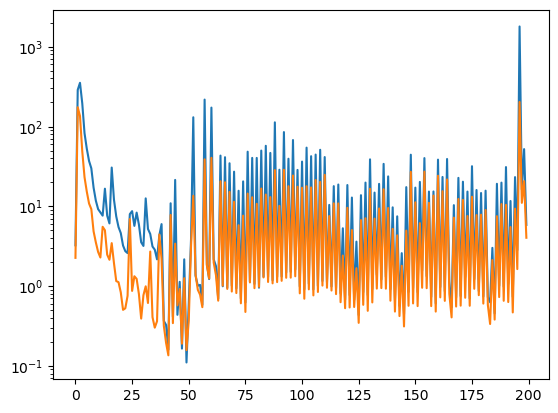

In [122]:
plt.plot(loss_params_samples)
plt.yscale('log')

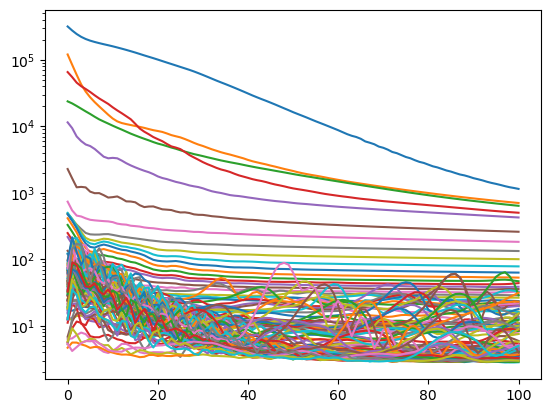

In [84]:
plt.plot(np.sum(loss_samples, axis=2).T)
plt.yscale('log')

In [85]:
(u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t) = grads(pinn_copy, data)
def to(arr):
    return arr.numpy().reshape(y_range.shape[0], x_range.shape[0])

actual_u_der = pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1]
actual_v_der = pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1]

u_der = pattern.params["D_u"]*( to(u_xx) + to(u_yy))# - to(u_t2)[-1, ...]
v_der = pattern.params["D_v"]*( to(v_xx)+ to(v_yy))# - to(v_t2)[-1, ...]
# X and Y are misoriented
u_der = u_der.T
v_der = v_der.T

u = pattern.c[0,:, : , -1]
v = pattern.c[1,:, : , -1]
f = u * u * v / (1.0 + kappa_u * u * u)
f_u =    rho_u * f - mu_u * u + sigma_u
f_v =  - rho_v * f + sigma_v

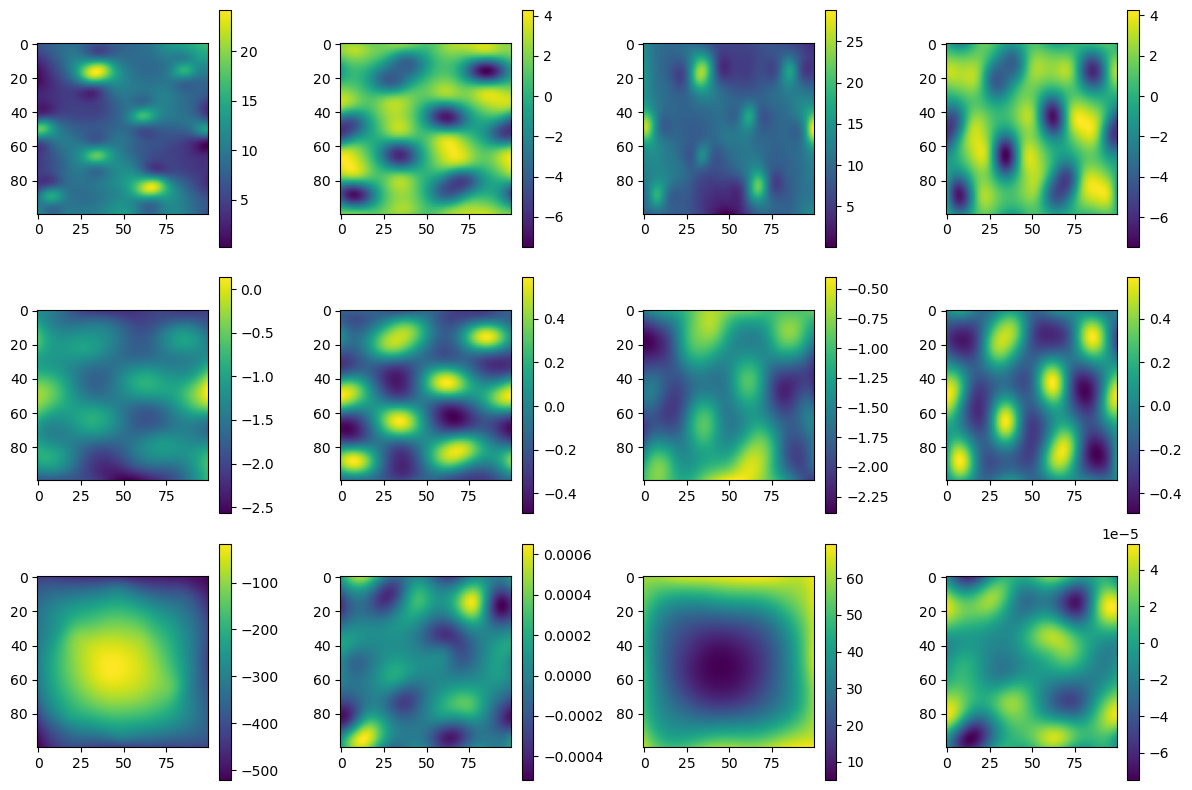

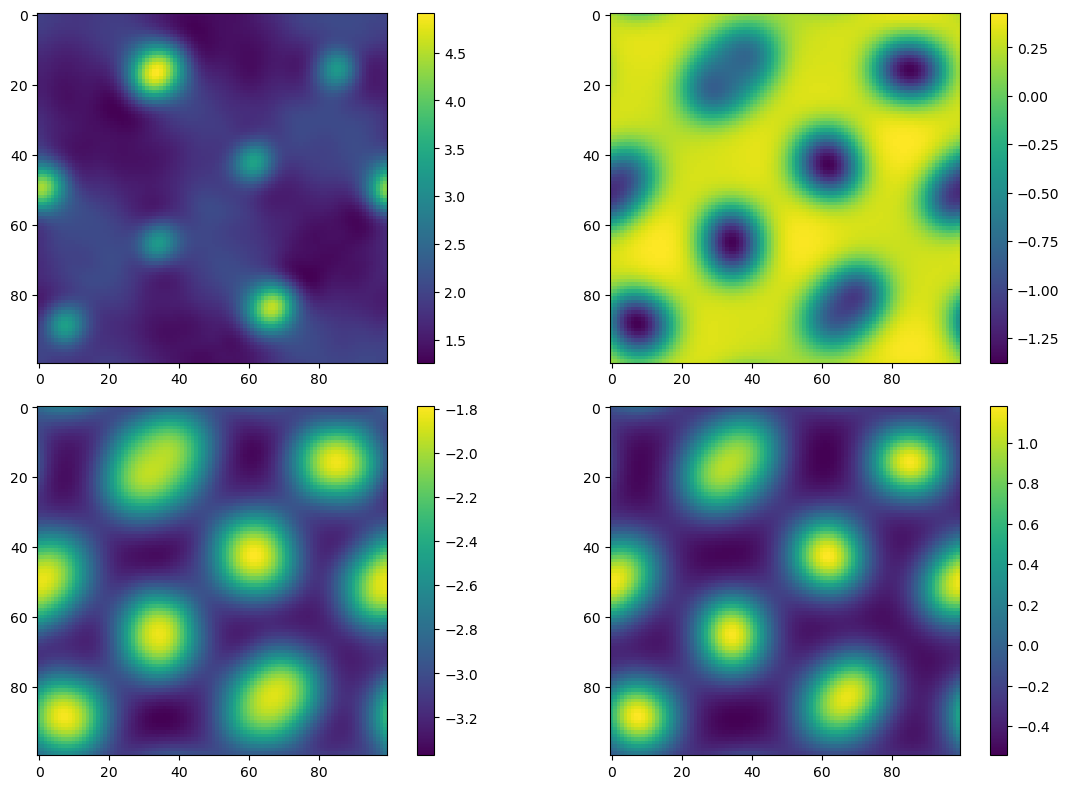

In [86]:
plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(to(u_xx).T)
plt.colorbar()
plt.subplot(342)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(343)
plt.imshow(to(u_yy).T)
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(to(v_xx).T)
plt.colorbar()
plt.subplot(346)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(347)
plt.imshow(to(v_yy).T)
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(to(u_t))
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(to(v_t))
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(u_der)
plt.colorbar()
plt.subplot(222)
plt.imshow(actual_u_der)
plt.colorbar()
plt.subplot(223)
plt.imshow(v_der)
plt.colorbar()
plt.subplot(224)
plt.imshow(actual_v_der)
plt.colorbar()
plt.tight_layout()
plt.show()

In [62]:
actual_u_der.shape

(100, 100)

In [124]:
def SE(ar1, ar2):
    return np.sum((ar1 - ar2)**2)
def RMSE(ar1, ar2):
    return np.sqrt(np.mean((ar1 - ar2)**2))
def RMSE_relative(ar1, ar2):
    return np.sqrt(np.mean((ar1/(ar2 + 1e-16) - 1)**2))
def max_diff(ar1, ar2):
    return np.max(np.abs(ar1 - ar2))

In [125]:
losses2[-1]

array([0.11357013, 0.09835291])

In [126]:
SE(f_u, -u_der)

0.08576705

In [127]:
SE(f_v, -v_der)

0.073835954

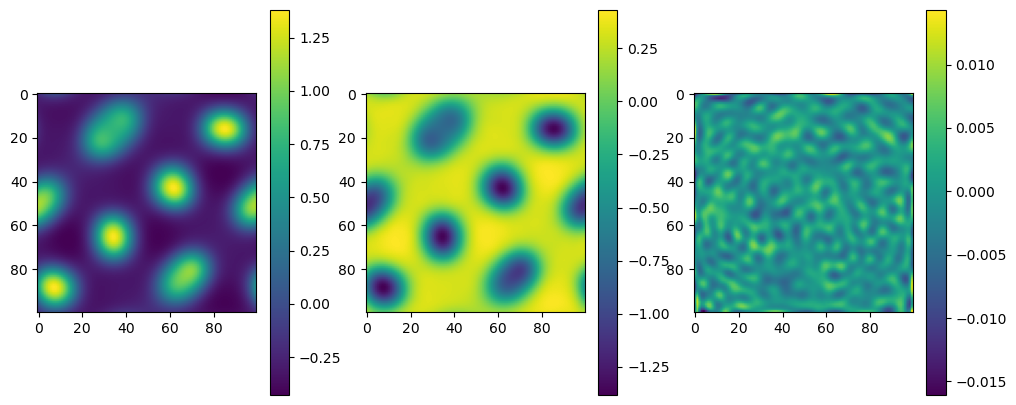

In [128]:
plt.figure(figsize=(12, 5))
plt.subplot(131)
plt.imshow(f_u)
plt.colorbar()
plt.subplot(132)
plt.imshow(u_der)
plt.colorbar()
plt.subplot(133)
plt.imshow(u_der+f_u)
plt.colorbar()

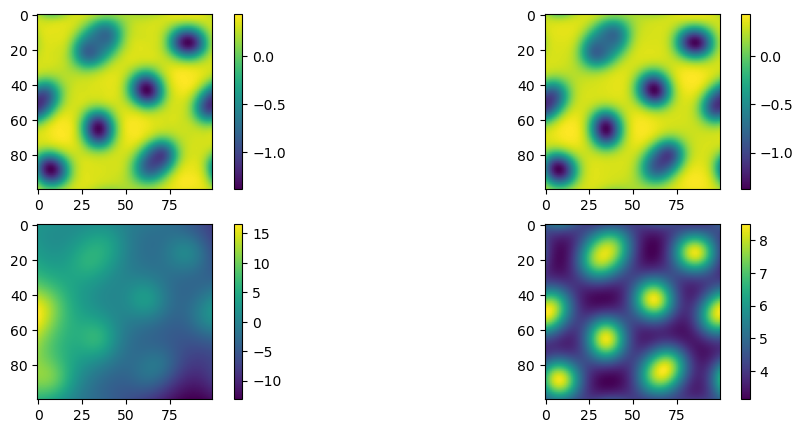

In [129]:

plt.figure(figsize=(12, 5))
plt.subplot(221)
plt.imshow(u_der)
plt.colorbar()
plt.subplot(222)
plt.imshow(actual_u_der)
plt.colorbar()
plt.subplot(223)
plt.imshow(u2.numpy().reshape(100, 100).T)
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[0, :, :, -1])
plt.colorbar()
plt.show()


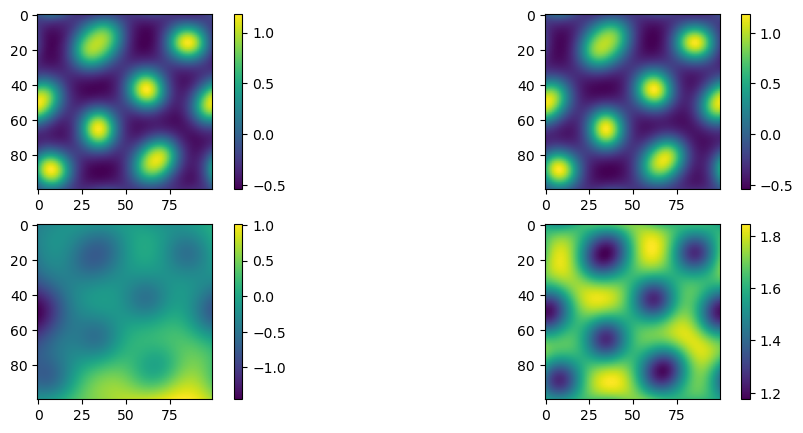

In [130]:

plt.figure(figsize=(12, 5))
plt.subplot(221)
plt.imshow(v_der)
plt.colorbar()
plt.subplot(222)
plt.imshow(actual_v_der)
plt.colorbar()
plt.subplot(223)
plt.imshow(v2.numpy().reshape(100, 100).T)
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1, :, :, -1])
plt.colorbar()
plt.show()

0.08576497741266086
0.0029285658164477173
0.7702825042211262
0.016073753997011053


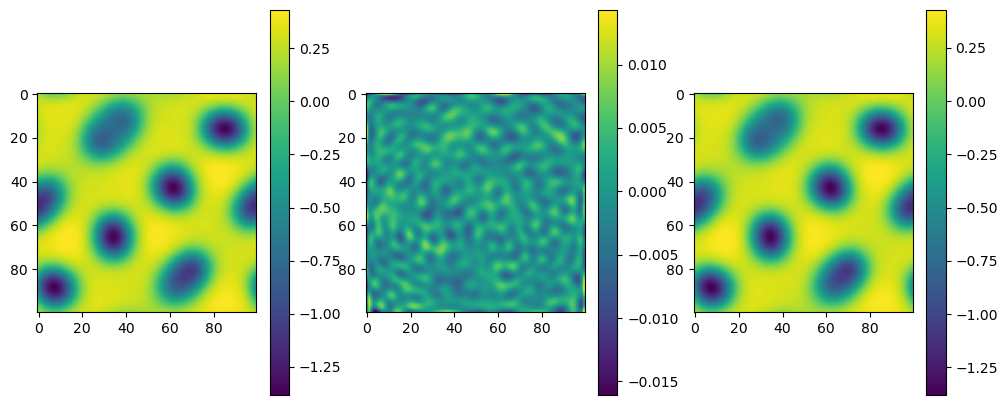

In [131]:

print(SE(u_der, actual_u_der))
print(RMSE(u_der, actual_u_der))
print(RMSE_relative(u_der, actual_u_der))
print(max_diff(u_der, actual_u_der))

plt.figure(figsize=(12, 5))
plt.subplot(131)
plt.imshow(u_der)
plt.colorbar()
plt.subplot(132)
plt.imshow(u_der-actual_u_der)
plt.colorbar()
plt.subplot(133)
plt.imshow(actual_u_der)
plt.colorbar()
plt.show()


0.0738359301545735
0.0027172767646041047
0.1423941186490741
0.015020870885919635


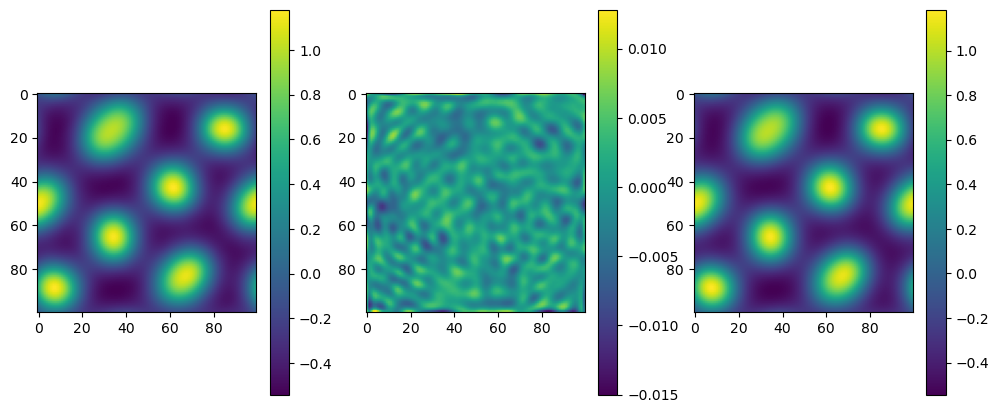

In [132]:
print(SE(v_der, actual_v_der))
print(RMSE(v_der, actual_v_der))
print(RMSE_relative(v_der, actual_v_der))
print(max_diff(v_der, actual_v_der))

plt.figure(figsize=(12, 5))
plt.subplot(131)
plt.imshow(v_der)
plt.colorbar()
plt.subplot(132)
plt.imshow(v_der-actual_v_der)
plt.colorbar()
plt.subplot(133)
plt.imshow(actual_v_der)
plt.colorbar()
plt.show()